In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp
import tf_keras
from tensorflow import keras
layers = keras.layers
tfb = tfp.bijectors
tfd = tfp.distributions
tf.random.set_seed(42)

import time

import scipy.stats as ms
import os
import functools
import warnings

import pandas as pd
import numpy as np
import numpy.linalg as la
from numpy import intersect1d, union1d
from numpy import argmax, argsort
from math import sqrt


import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

plt.style.use("ggplot")
warnings.filterwarnings('ignore')


#I. Data preparation

> Defining Models data

In [ ]:
import gzip

with gzip.open("/data_hub/compressed_data.csv.gz", "rt") as f:
    dataset_2d = pd.read_csv(f)




In [ ]:
round_dataset_2d = dataset_2d.to_numpy().round(2)
dataset = round_dataset_2d.reshape(-1, 10, 12)

ds_ahp_dataset = round_dataset_2d.reshape(-1,10)*100
pca_dataset = round_dataset_2d.reshape(-1,12)
vae_dataset = np.expand_dims(dataset, axis = -1)


In [ ]:
print("pca dataset shape : {}".format(pca_dataset.shape))
print("vae dataset shape : {}".format(vae_dataset.shape))
print("ds/ahp dataset shape : {}".format(ds_ahp_dataset.shape))

pca dataset shape : (450000, 12)
vae dataset shape : (45000, 10, 12, 1)
ds/ahp dataset shape : (540000, 10)


In [ ]:
train_data = (tf.data.Dataset.from_tensor_slices(vae_dataset)
                 .shuffle(45000).batch(32))

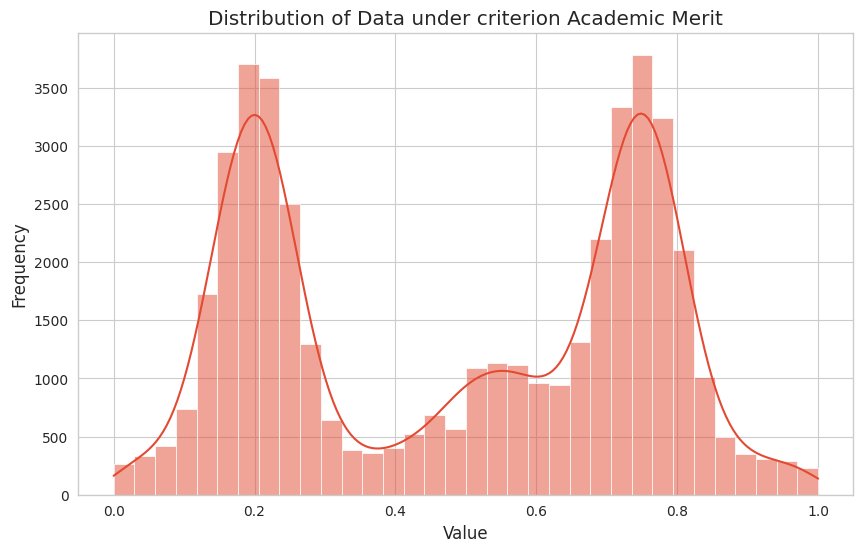

In [ ]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))
sns.histplot(dataset[:,0,0], kde=True)
plt.title("Distribution of Data under criterion Academic Merit")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()


#II. Prior analysis : Criteria pairwise comparisons and Consensus building

> To derive Criteria priority values

> To build Group Consensus among DMs





##Helper Functions

In [ ]:
def get_criteria_comparison_data(file_path, DM_number, criteria_number):
  skiprows = 0
  data = dict()
  for i in range(DM_number):
    DM = "DM{}".format(i+1)
    data[DM] = tf.Variable(pd.read_excel(file_path, engine = 'openpyxl', usecols="B:M", skiprows=skiprows, nrows=12), dtype = 'float32')
    skiprows += criteria_number + 1
  return data

In [ ]:
def update_cons_tf(tensor1, tensor2, cons_matrix):


    # Let's create two masks. The first will be True for the upper triangular part of the tensor
    # and the latter will be True for lower part

    mask1 = tf.cast(tf.linalg.band_part(tf.ones_like(cons_matrix), 0, -1), dtype = tf.bool)  # Upper triangular mask (i < j)
    mask2 = tf.cast(tf.linalg.band_part(tf.ones_like(cons_matrix), -1, 0), dtype = tf.bool) # Lower part mask
    condition = tf.abs(cons_matrix) > tf.abs(tf.transpose(cons_matrix))

    #updating tensor1 and tensor2 based on the condition
    tensor1_new = tf.where(condition, tensor1 - cons_matrix, tensor1)
    tensor2_new = tf.where(condition, tensor2 + cons_matrix, tensor2)
    tensor1_new = tf.where((mask1 & condition) | (mask2 & condition), tensor1_new, tf.where((mask1 ^ condition) & (mask2 ^ condition), tensor1_new, 1.0/tf.transpose(tensor1_new)))
    tensor2_new = tf.where((mask1 & condition) | (mask2 & condition), tensor2_new, tf.where((mask1 ^ condition) & (mask2 ^ condition), tensor2_new, 1.0/tf.transpose(tensor2_new)))



    return tensor1_new, tensor2_new


In [ ]:
def get_distance_matrix(criteria_comparison_data, DM_number):

    # Calculate pairwise distances for all pairs using broadcasting

    DMs = list(criteria_comparison_data.keys())
    pairwise_arrays = [criteria_comparison_data[DM] for DM in DMs]
    pairwise_tensor1 = tf.stack([tf.stack(pairwise_arrays, axis = 0)]*DM_number, axis = 0)
    pairwise_tensor2 = tf.stack([tf.stack([t]*DM_number, axis = 0) for t in pairwise_arrays], axis = 0)

    diff = pairwise_tensor1 - pairwise_tensor2  # Shape: (DM_number, DM_number, tensor_shape)
    distance_matrix = tf.linalg.norm(diff, ord='fro', axis=[-2, -1])   # Shape: (DM_number, DM_number)


    return distance_matrix


In [ ]:
def normalization(PC_tensor):
    return PC_tensor/tf.reduce_sum(PC_tensor, axis = 0)

In [ ]:
def CPVs(PC_tensor, criteria: list):
    PCM = normalization(PC_tensor)
    priorities = {}
    n = PCM.shape[0]
    sum_tab = tf.reduce_sum(PCM, axis = 1)
    for i in range(n):
        priorities[criteria[i]] = sum_tab[i] / n

    return priorities

In [ ]:
def criteria_priority_values(criteria_data ,criteria, DMs):
  priorities = list()
  for dm in DMs:
    normalized_PCM = normalization(criteria_data[dm])
    priorities.append(CPVs(normalized_PCM, criteria))
  return priorities

In [ ]:
def are_consent(pairwise_tensor1, pairwise_tensor2, max_dist):
  return not tf.reduce_any(tf.abs(pairwise_tensor1-pairwise_tensor2) > max_dist)

In [ ]:
def consensus_operation(criteria_comparison_data, consensus_level, DMs, index_max_dist):
  consensus_index = consensus_level/2
  i,j = index_max_dist
  dm1 = DMs[i]
  dm2 = DMs[j]
  num_cr = criteria_comparison_data[dm1].shape[0]
  tensor1 = tf.Variable(tf.zeros((num_cr,num_cr)))
  tensor2 = tf.Variable(tf.zeros((num_cr,num_cr)))
  tensor1.assign(criteria_comparison_data[dm1])
  tensor2.assign(criteria_comparison_data[dm2])

  consensus_matrix = (tensor1 - tensor2)*consensus_index
  return update_cons_tf(tensor1, tensor2, consensus_matrix)

In [ ]:
def distance(pairwise_tensor1, pairwise_tensor2):
  return tf.linalg.norm(pairwise_tensor1-pairwise_tensor2)

In [ ]:
def consensus_training(criteria_comparison_data, consensus_level,scale_value, DM_number, epochs):
  max_allowed_dist = (scale_value-1/scale_value)*(1-consensus_level)
  DMs = list(criteria_comparison_data.keys())
  n = 0
  cons_loss = []
  while True:
    start_time = time.time()
    n += 1
    distance_matrix = get_distance_matrix(criteria_comparison_data, DM_number)
    index_max_dist = np.unravel_index(np.argmax(distance_matrix), distance_matrix.shape)
    i, j = index_max_dist
    dm1 = DMs[i]
    dm2 = DMs[j]
    tensor1 = criteria_comparison_data[dm1]
    tensor2 = criteria_comparison_data[dm2]
    if are_consent(tensor1, tensor2,max_allowed_dist):
      return cons_loss
    t1, t2 = consensus_operation(criteria_comparison_data, consensus_level, DMs,index_max_dist)
    tensor1.assign(t1)
    tensor2.assign(t2)
    end_time = time.time()
    exec_time = np.round(end_time - start_time, 2)
    dist = tf.reduce_sum(distance_matrix).numpy()/2
    cons_loss.append(dist)
    print("epoch : {}  time : {}s  distance : {}".format(n,exec_time,dist))
    if n == epochs:
      return cons_loss

##Consensus building

###**Step 1:** Consensus level tuning
**The best consensus level minimizes the distance between all decision makers**

In [ ]:
path = '/data_hub/criteria_comparison.xlsx'
consensus_data = get_criteria_comparison_data(path,10,12)
raw_data = get_criteria_comparison_data(path,10,12)

In [ ]:
L = list()
for i in list(np.linspace(0.01,1, 100)):
  consensus_data = get_criteria_comparison_data(path,10,12)
  consensus_training(consensus_data,i,9,10,10)
  D  = get_distance_matrix(consensus_data,10)
  L.append(np.sum(D))



epoch : 1  time : 0.01s  distance : 1336.8438720703125
epoch : 2  time : 0.02s  distance : 1316.3038330078125
epoch : 3  time : 0.01s  distance : 1296.79296875
epoch : 4  time : 0.01s  distance : 1277.8065185546875
epoch : 5  time : 0.02s  distance : 1259.3675537109375
epoch : 1  time : 0.01s  distance : 1336.8438720703125
epoch : 2  time : 0.01s  distance : 1314.5238037109375
epoch : 3  time : 0.01s  distance : 1293.3079833984375
epoch : 4  time : 0.01s  distance : 1272.64404296875
epoch : 5  time : 0.01s  distance : 1252.65185546875
epoch : 1  time : 0.01s  distance : 1336.8438720703125
epoch : 2  time : 0.01s  distance : 1312.7576904296875
epoch : 3  time : 0.01s  distance : 1289.8472900390625
epoch : 4  time : 0.01s  distance : 1267.513916015625
epoch : 5  time : 0.01s  distance : 1245.9869384765625
epoch : 1  time : 0.01s  distance : 1336.8438720703125
epoch : 2  time : 0.01s  distance : 1311.005126953125
epoch : 3  time : 0.01s  distance : 1286.410888671875
epoch : 4  time : 0.01

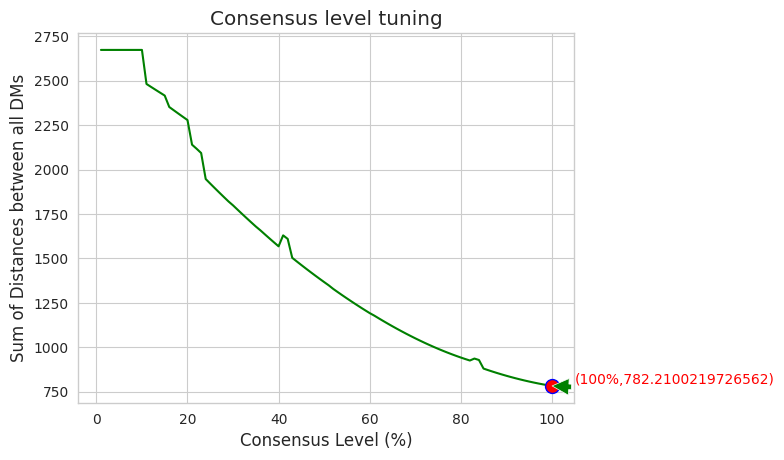

In [ ]:
x = np.argmin(L)
y = L[x]


Text = "({}%,{})".format(x+1,round(y,2))
plt.plot(range(1,101),L, color="green")
plt.plot(x+1, y, marker='o', markersize=10, markerfacecolor='red', markeredgecolor='blue')
plt.xlabel("Consensus Level (%)")
plt.ylabel("Sum of Distances between all DMs")
plt.annotate(Text, xy=(x+1, y), xytext=(x+6, y+10),
            arrowprops=dict(facecolor='green', shrink=0.01), color="red"
            )
plt.title("Consensus level tuning")
plt.show()

###**Step 2 :** Training with Consensus level of 100%

In [ ]:
cons_loss = consensus_training(consensus_data, 1, 9, 10, 40)

epoch : 1  time : 3.61s  distance : 1336.8438720703125
epoch : 2  time : 0.03s  distance : 1217.50830078125
epoch : 3  time : 0.04s  distance : 1098.658447265625
epoch : 4  time : 0.04s  distance : 978.9969482421875
epoch : 5  time : 0.03s  distance : 865.80419921875
epoch : 6  time : 0.02s  distance : 751.7351684570312
epoch : 7  time : 0.03s  distance : 692.689208984375
epoch : 8  time : 0.02s  distance : 591.701416015625
epoch : 9  time : 0.02s  distance : 528.7433471679688
epoch : 10  time : 0.05s  distance : 425.3546447753906
epoch : 11  time : 0.03s  distance : 391.1040344238281
epoch : 12  time : 0.02s  distance : 326.13104248046875
epoch : 13  time : 0.05s  distance : 299.69549560546875
epoch : 14  time : 0.02s  distance : 250.17774963378906
epoch : 15  time : 0.02s  distance : 217.55960083007812
epoch : 16  time : 0.02s  distance : 163.38694763183594
epoch : 17  time : 0.04s  distance : 142.20101928710938
epoch : 18  time : 0.05s  distance : 106.2887191772461
epoch : 19  time 

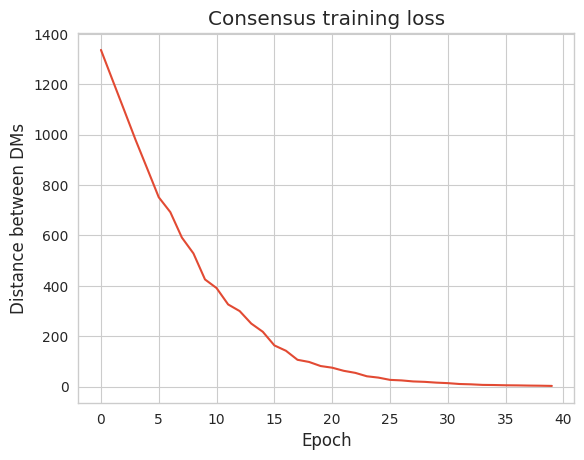

In [ ]:
plt.plot(cons_loss)
plt.xlabel("Epoch")
plt.ylabel("Distance between DMs")
plt.title("Consensus training loss")
plt.savefig("cons_loss")
plt.show()

###Step 3: Determining CPVs





In [ ]:
criteria = ["Academic Merit","Extracurricular Involvement", "Leadership Potential",
            "Community Impact","Innovation and Creativity","Financial Need","Personal Statement Quality",
            "Letters of Recommendation","Alignment with Foundation's Mission","Research Potential","Communication Skills",
            "Diversity and Inclusion"]

In [ ]:
priorities = criteria_priority_values(consensus_data, criteria, list(consensus_data.keys()))

In [ ]:

all_values = [list(d.values()) for d in priorities]
all_values = np.array(all_values)
priority_tensor = tf.transpose(tf.constant(all_values))

In [ ]:
priorities = tf.reduce_mean(priority_tensor, axis = 1)

#III. ML Model : Inferring Principal Axes for easy alternatives ranking

**Trained using _Variational Inferece_ and _Maximum A Posteriori_ with :**

> Gaussians mixture posterior

> Simple Normal Posterior

##Model Definitions

In [ ]:
def normal_ppca(data_dim, latent_dim, num_datapoints, stddv_datapoints):
  w = yield tfd.Normal(loc=tf.zeros([data_dim, latent_dim]),
                 scale=2.0 * tf.ones([data_dim, latent_dim]),
                 name="w")
  z = yield tfd.Normal(loc=tf.zeros([latent_dim, num_datapoints]),
                 scale=tf.ones([latent_dim, num_datapoints]),
                 name="z")
  x = yield tfd.Normal(loc= tf.math.sigmoid(tf.matmul(w, z)),
                       scale=stddv_datapoints,
                       name="x")

In [ ]:
def gaussian_mixture_ppca(data_dim, latent_dim, num_datapoints, stddv_datapoints):
  w = yield tfd.Normal(loc=tf.zeros([data_dim, latent_dim]),
                 scale=tf.ones([data_dim, latent_dim]),
                 name="w")
  z1 = yield tfd.Normal(loc=tf.zeros([latent_dim, num_datapoints]),
                 scale=0.3*tf.ones([latent_dim, num_datapoints]),
                 name="z1")
  z2 = yield tfd.Normal(loc=tf.zeros([latent_dim, num_datapoints]),
                 scale=0.4*tf.ones([latent_dim, num_datapoints]),
                 name="z2")
  x = yield tfd.MixtureSameFamily(
                  mixture_distribution=tfd.Categorical(probs=[0.5, 0.5]),
                  components_distribution=tfd.Normal(loc=tf.stack([tf.math.sigmoid(tf.matmul(w, z1)), tf.math.sigmoid(tf.matmul(w, z2))], axis = -1),
                                                        scale=stddv_datapoints),
                       name="x")

In [ ]:
data_dim = 12
latent_dim = 2
num_datapoints = 450000
n_stddv_datapoints = .04
gm_stddv_datapoints = .04
my_data = tf.constant(pca_dataset, dtype=tf.float32)
my_data.shape


TensorShape([450000, 12])

In [ ]:
normal_ppca_model = functools.partial(normal_ppca,
    data_dim=data_dim,
    latent_dim=latent_dim,
    num_datapoints=num_datapoints,
    stddv_datapoints=n_stddv_datapoints)

normal_model = tfd.JointDistributionCoroutineAutoBatched(normal_ppca_model)

In [ ]:
gm_ppca_model = functools.partial(gaussian_mixture_ppca,
    data_dim=data_dim,
    latent_dim=latent_dim,
    num_datapoints=num_datapoints,
    stddv_datapoints=gm_stddv_datapoints)

gm_model = tfd.JointDistributionCoroutineAutoBatched(gm_ppca_model)

In [ ]:
normal_trainable_vars = {
    "w": tf.Variable(tf.random.normal([data_dim, latent_dim])),
    "z": tf.Variable(tf.random.normal([latent_dim, num_datapoints])),

}

# Define loss function
def target_normal_log_prob_fn(w = normal_trainable_vars["w"], z = normal_trainable_vars["z"]):
    return normal_model.log_prob((w, z, tf.transpose(my_data)))

# Define optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

# Training loop
num_steps = 900
losses = []

for step in range(num_steps):
    with tf.GradientTape() as tape:
        loss = -target_normal_log_prob_fn()
    grads = tape.gradient(loss, normal_trainable_vars.values())
    optimizer.apply_gradients(zip(grads, normal_trainable_vars.values()))
    losses.append(loss.numpy())

    if step % 10 == 0:
        print(f"Step {step}: Loss = {loss.numpy():.4f}")

Step 0: Loss = 200461216.0000
Step 10: Loss = 178669504.0000
Step 20: Loss = 160970672.0000
Step 30: Loss = 147235536.0000
Step 40: Loss = 136738912.0000
Step 50: Loss = 128637024.0000
Step 60: Loss = 122098592.0000
Step 70: Loss = 116195016.0000
Step 80: Loss = 109721456.0000
Step 90: Loss = 101192192.0000
Step 100: Loss = 89492848.0000
Step 110: Loss = 75013664.0000
Step 120: Loss = 59822688.0000
Step 130: Loss = 46422436.0000
Step 140: Loss = 36358236.0000
Step 150: Loss = 29750412.0000
Step 160: Loss = 25795476.0000
Step 170: Loss = 23530210.0000
Step 180: Loss = 22240146.0000
Step 190: Loss = 21492782.0000
Step 200: Loss = 21046470.0000
Step 210: Loss = 20768658.0000
Step 220: Loss = 20586570.0000
Step 230: Loss = 20459802.0000
Step 240: Loss = 20365284.0000
Step 250: Loss = 20289478.0000
Step 260: Loss = 20224314.0000
Step 270: Loss = 20164918.0000
Step 280: Loss = 20108370.0000
Step 290: Loss = 20052932.0000
Step 300: Loss = 19997608.0000
Step 310: Loss = 19941860.0000
Step 320:

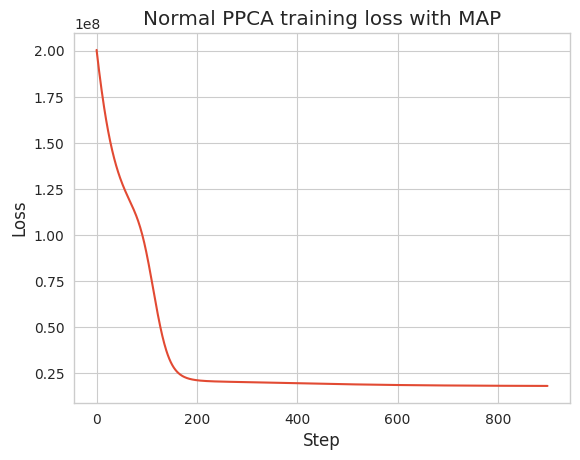

In [ ]:
plt.plot(losses)
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Normal PPCA training loss with MAP")
plt.savefig("normal_map_loss")
plt.show()

MAP-estimated axes:
<tf.Variable 'Variable:0' shape=(12, 2) dtype=float32, numpy=
array([[-0.99368787, -0.6850072 ],
       [-0.7911386 , -0.93457747],
       [-0.9209542 , -0.77094185],
       [-0.7584301 , -0.97875226],
       [-0.82683796, -0.88893294],
       [-0.9316881 , -0.7565703 ],
       [-0.595389  , -1.1910918 ],
       [-0.90576494, -0.7899143 ],
       [-0.5459726 , -1.2625564 ],
       [-1.067403  , -0.5905611 ],
       [-0.9428411 , -0.7372912 ],
       [-1.1546485 , -0.49807516]], dtype=float32)>


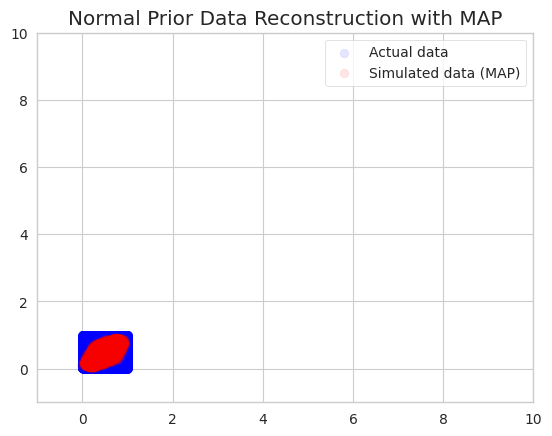

In [ ]:
print("MAP-estimated axes:")
print(normal_trainable_vars['w'])

_, _, x_generated = normal_model.sample(value=(normal_trainable_vars['w'], normal_trainable_vars['z'], None))

plt.scatter(tf.transpose(my_data)[0, :], tf.transpose(my_data)[1, :], color='blue', alpha=0.1, label='Actual data')
plt.scatter(x_generated[0, :], x_generated[1, :], color='red', alpha=0.1, label='Simulated data (MAP)')
plt.title("Normal Prior Data Reconstruction with MAP")
plt.legend()
plt.axis([-1, 10, -1, 10])
plt.savefig("normal_map_gen")
plt.show()

In [ ]:

gm_trainable_vars = {
    "w": tf.Variable(tf.random.normal([data_dim, latent_dim])),
    "z1": tf.Variable(tf.random.normal([latent_dim, num_datapoints])),
    "z2": tf.Variable(tf.random.normal([latent_dim, num_datapoints])),

}

# Define loss function
def target_gm_log_prob_fn(w = gm_trainable_vars["w"], z1 = gm_trainable_vars["z1"], z2 = gm_trainable_vars["z2"]):
    return gm_model.log_prob((w, z1, z2, tf.transpose(my_data)))

# Define optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)  # Lower LR for stability

# Training loop
num_steps = 900
losses = []

for step in range(num_steps):
    with tf.GradientTape() as tape:
        loss = -target_gm_log_prob_fn()
    grads = tape.gradient(loss, gm_trainable_vars.values())
    optimizer.apply_gradients(zip(grads, gm_trainable_vars.values()))
    losses.append(loss.numpy())

    if step % 10 == 0:
        print(f"Step {step}: Loss = {loss.numpy():.4f}")

Step 0: Loss = 98272208.0000
Step 10: Loss = 82955920.0000
Step 20: Loss = 70863104.0000
Step 30: Loss = 60476052.0000
Step 40: Loss = 51097116.0000
Step 50: Loss = 42678676.0000
Step 60: Loss = 35166940.0000
Step 70: Loss = 28365220.0000
Step 80: Loss = 22245364.0000
Step 90: Loss = 17277846.0000
Step 100: Loss = 13664403.0000
Step 110: Loss = 11076415.0000
Step 120: Loss = 9163306.0000
Step 130: Loss = 7702744.0000
Step 140: Loss = 6557545.0000
Step 150: Loss = 5640716.0000
Step 160: Loss = 4894158.0000
Step 170: Loss = 4277185.5000
Step 180: Loss = 3761457.5000
Step 190: Loss = 3326046.7500
Step 200: Loss = 2954455.5000
Step 210: Loss = 2634091.5000
Step 220: Loss = 2355030.5000
Step 230: Loss = 2108907.2500
Step 240: Loss = 1890344.0000
Step 250: Loss = 1694992.7500
Step 260: Loss = 1518513.6250
Step 270: Loss = 1358343.2500
Step 280: Loss = 1212379.5000
Step 290: Loss = 1078759.5000
Step 300: Loss = 954748.5000
Step 310: Loss = 839861.8750
Step 320: Loss = 732835.1250
Step 330: Lo

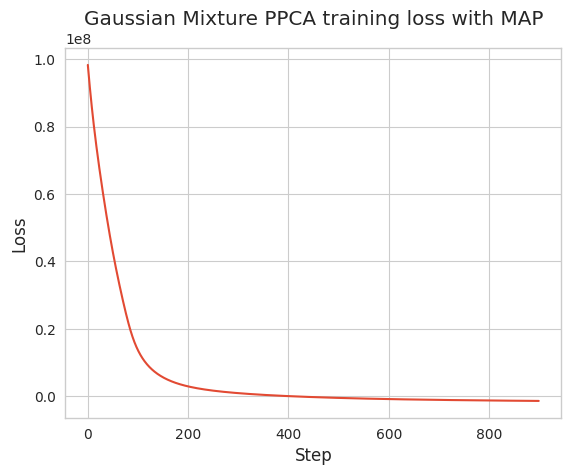

In [ ]:
plt.plot(losses)
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Gaussian Mixture PPCA training loss with MAP")
plt.savefig("gm_map_loss")
plt.show()

MAP-estimated axes:
<tf.Variable 'Variable:0' shape=(12, 2) dtype=float32, numpy=
array([[ 2.2064643, -2.6288476],
       [-2.370454 ,  2.4556305],
       [ 2.6828828,  2.6025658],
       [ 2.2870014, -2.4830246],
       [-2.3925643,  2.4143167],
       [ 2.6546881,  2.588258 ],
       [-2.8683047, -2.886943 ],
       [-2.3946471,  2.433808 ],
       [ 2.2232351, -2.5950644],
       [ 2.2713122, -2.5015008],
       [ 2.6445494,  2.5763915],
       [ 2.2284214, -2.571323 ]], dtype=float32)>


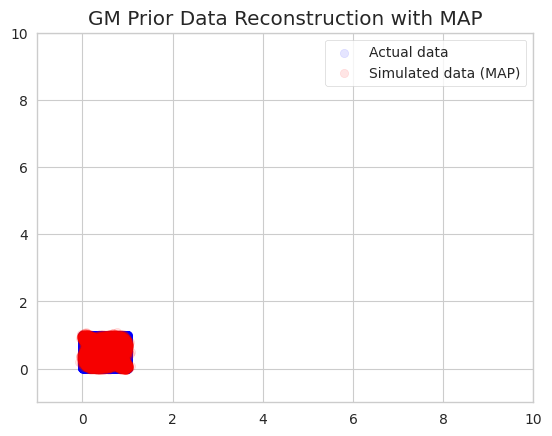

In [ ]:
print("MAP-estimated axes:")
print(gm_trainable_vars['w'])

_, _, _, x_generated = gm_model.sample(value=(gm_trainable_vars['w'],gm_trainable_vars['z1'], gm_trainable_vars['z2'], None))

plt.scatter(tf.transpose(my_data)[0, :], tf.transpose(my_data)[1, :], color='blue', alpha=0.1, label='Actual data')
plt.scatter(x_generated[0, :], x_generated[1, :], color='red', alpha=0.1, label='Simulated data (MAP)')

plt.legend()
plt.title("GM Prior Data Reconstruction with MAP")
plt.axis([-1, 10, -1, 10])
plt.savefig("gm_map_gen")
plt.show()

In [ ]:
qw_mean = tf.Variable(tf.random.normal([data_dim, latent_dim]))
qz_mean = tf.Variable(tf.random.normal([latent_dim, num_datapoints]))
qw_stddv = tfp.util.TransformedVariable(1e-4 * tf.ones([data_dim, latent_dim]),
                                        bijector=tfb.Softplus())
qz_stddv = tfp.util.TransformedVariable(
    1e-4 * tf.ones([latent_dim, num_datapoints]),
    bijector=tfb.Softplus())
def factored_normal_variational_model():
  qw = yield tfd.Normal(loc=qw_mean, scale=qw_stddv, name="qw")
  qz = yield tfd.Normal(loc=qz_mean, scale=qz_stddv, name="qz")

surrogate_posterior = tfd.JointDistributionCoroutineAutoBatched(
    factored_normal_variational_model)

n_losses = tfp.vi.fit_surrogate_posterior(
    target_normal_log_prob_fn,
    surrogate_posterior=surrogate_posterior,
    optimizer=tf_keras.optimizers.Adam(learning_rate=0.01),
    num_steps=900)

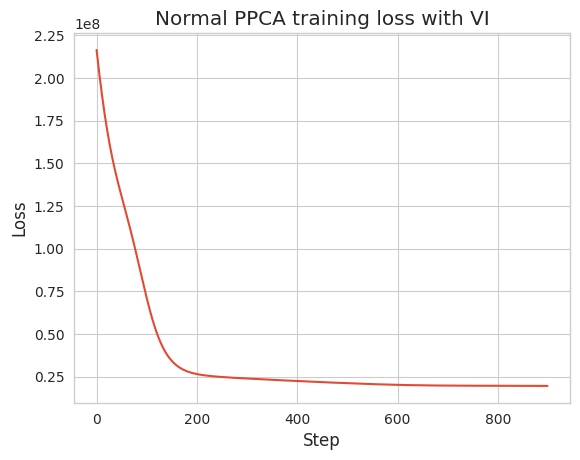

In [ ]:
plt.plot(n_losses)
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Normal PPCA training loss with VI")
plt.savefig("normal_vi_loss")
plt.show()

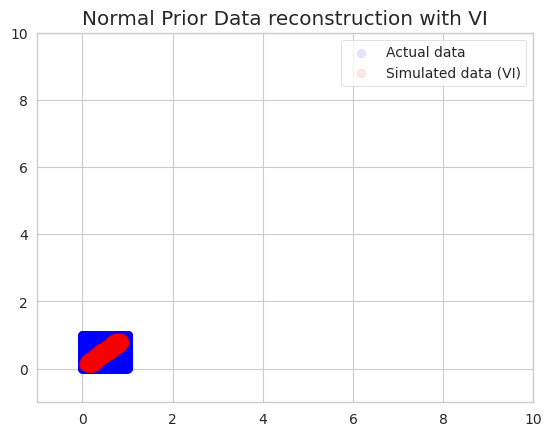

In [ ]:
posterior_samples = surrogate_posterior.sample(50)
n_w, _, x_generated = normal_model.sample(value=(posterior_samples))

# It's a pain to plot all 5000 points for each of our 50 posterior samples, so
# let's subsample to get the gist of the distribution.
x_generated = tf.reshape(x_generated[0, :, :],(12, -1))
plt.scatter(tf.transpose(my_data)[2, :], tf.transpose(my_data)[4, :], color='blue', alpha=0.1, label='Actual data')
plt.scatter(x_generated[2, :], x_generated[4, :], color='red', alpha=0.1, label='Simulated data (VI)')
plt.title("Normal Prior Data reconstruction with VI")
plt.legend()
plt.axis([-1, 10, -1, 10])
plt.savefig("normal_vi_gen")
plt.show()

In [ ]:
qw_mean = tf.Variable(tf.random.normal([data_dim, latent_dim]))
qz1_mean = tf.Variable(tf.random.normal([latent_dim, num_datapoints]))
qz2_mean = tf.Variable(tf.random.normal([latent_dim, num_datapoints]))
qw_stddv = tfp.util.TransformedVariable(1e-4 * tf.ones([data_dim, latent_dim]),
                                        bijector=tfb.Softplus())
qz_stddv = tfp.util.TransformedVariable(
    1e-4 * tf.ones([latent_dim, num_datapoints]),
    bijector=tfb.Softplus())
def factored_gm_variational_model():
  qw = yield tfd.Normal(loc=qw_mean, scale=qw_stddv, name="qw")
  qz1 = yield tfd.Normal(loc=qz1_mean, scale=qz_stddv, name="qz1")
  qz2 = yield tfd.Normal(loc=qz2_mean, scale=qz_stddv, name="qz2")

gm_surrogate_posterior = tfd.JointDistributionCoroutineAutoBatched(
    factored_gm_variational_model)

losses = tfp.vi.fit_surrogate_posterior(
    target_gm_log_prob_fn,
    surrogate_posterior=gm_surrogate_posterior,
    optimizer=tf_keras.optimizers.Adam(learning_rate=0.01),
    num_steps=900)

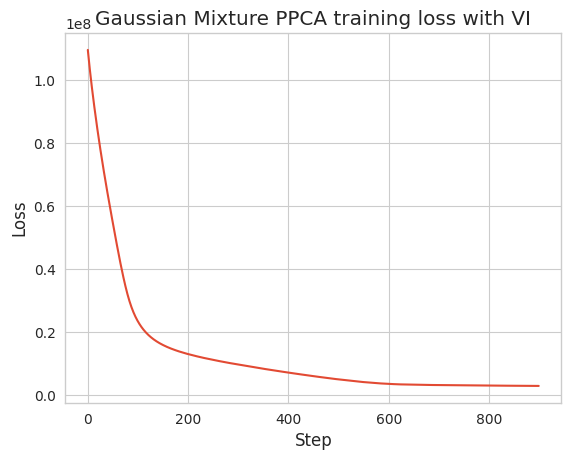

In [ ]:
plt.plot(losses)
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Gaussian Mixture PPCA training loss with VI")

plt.show()

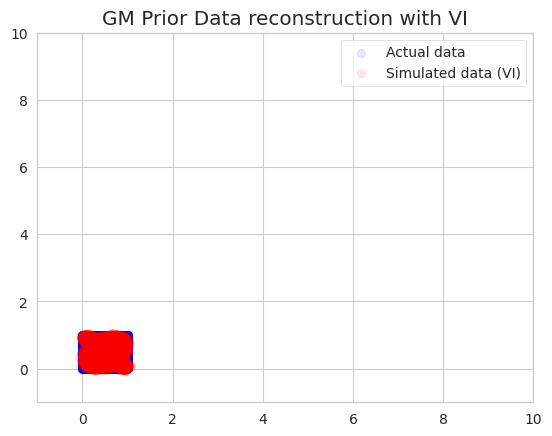

In [ ]:
posterior_samples = gm_surrogate_posterior.sample(50)
gm_w, _, _, x_generated = gm_model.sample(value=(posterior_samples))

# It's a pain to plot all 5000 points for each of our 50 posterior samples, so
# let's subsample to get the gist of the distribution.
# x_generated = tf.reshape(tf.transpose(x_generated, [1, 0, 2]), (2, -1))[:, ::47]
x_generated = tf.reshape(x_generated[0, :, :],(12, -1))
plt.scatter(tf.transpose(my_data)[2, :], tf.transpose(my_data)[4, :], color='blue', alpha=0.1, label='Actual data')
plt.scatter(x_generated[2, :], x_generated[4, :], color='red', alpha=0.1, label='Simulated data (VI)')
plt.title("GM Prior Data reconstruction with VI")
plt.legend()
plt.axis([-1, 10, -1, 10])
plt.savefig("gm_vi_gen")
plt.show()

#IV. Altenative Ranking

In [ ]:
inferred_axes = gm_trainable_vars['w']

In [ ]:
model_data = tf.reduce_mean(tf.reshape(vae_dataset, shape = (45000,10,-1)), axis = 1)

In [ ]:
def get_alternative_scores(pca_data, inferred_axes, priority_tensor):
  reduced_data = tf.matmul(tf.cast(pca_data,tf.float32), inferred_axes)
  inferred_priorities = tf.nn.softmax(tf.matmul(tf.transpose(inferred_axes), tf.expand_dims(priorities, axis = 1)), axis = 0)
  final_scores = tf.nn.softmax(tf.matmul(reduced_data, inferred_priorities),axis=0)
  return final_scores

def get_n_best_alternatives_dataframe(final_scores, n):
  indices = tf.argsort(final_scores, axis = 0, direction = "DESCENDING")
  best_n_alt = indices[:n]
  best_n_scores = tf.reshape(tf.gather(final_scores, best_n_alt),shape = (n,-1))
  data = {'Alternative': best_n_alt.numpy().flatten(), 'Score': best_n_scores.numpy().flatten()}
  ranking_df = pd.DataFrame(data, index = range(1,n+1))
  return ranking_df

In [ ]:
final_scores = get_alternative_scores(model_data, inferred_axes, priorities)
final_scores = final_scores*1e+7
df = get_n_best_alternatives_dataframe(final_scores, 100)
df

,Alternative,Score
1,16056,825.940857
2,22953,756.399475
3,22989,713.961792
4,15705,708.098022
5,40720,703.817810
...,...,...
96,2946,638.845032
97,16238,638.699524
98,16391,638.451904
99,20460,638.365173


#V. Sensitivity Analysis

In [64]:
def get_sensitivity_index(pca_dataset, inferred_axes, priority_tensor, delta):
  '''
  '''
  n = inferred_axes.shape[0]
  initializer = tf.keras.initializers.Identity()
  n_identity = initializer(shape=(n, n))
  n_priority_tensor = tf.reshape(tf.stack([priority_tensor]*n, axis = 1), shape = (n,-1))
  shifted_priorities = []
  for i in range(n):
      current_priorities = n_priority_tensor[:, i]
      reduction_amount = delta * current_priorities[i]
      current_priorities = tf.tensor_scatter_nd_sub(current_priorities, [[i]], [reduction_amount])
      other_indices = tf.constant([j for j in range(n) if j != i])
      distribution_amount = reduction_amount / (n - 1)
      current_priorities = tf.tensor_scatter_nd_add(current_priorities, tf.expand_dims(other_indices, axis=-1), [distribution_amount] * (n - 1))

      shifted_priorities.append(current_priorities)

  n_priority_tensor = tf.transpose(tf.stack(shifted_priorities))
  inferred_priorities = tf.nn.softmax(tf.matmul(tf.transpose(inferred_axes), n_priority_tensor), axis = 0)
  reduced_data = tf.matmul(tf.cast(pca_dataset,tf.float32), inferred_axes)
  final_scores = tf.nn.softmax(tf.matmul(reduced_data, inferred_priorities),axis=0)
  sum_scores = tf.reduce_sum(final_scores, axis=1, keepdims=True)  # Keep the dimension
  sensitivity_index = tf.reduce_mean(tf.reduce_mean(tf.abs(-n * final_scores + sum_scores) / delta, axis=1), axis=0)
  return sensitivity_index

def get_sensitivity_graph(pca_dataset, inferred_axes, priority_tensor):
  deltas = np.arange(0.01, 1, 0.001)
  sensitivity_indices = []
  for delta in deltas:
    sensitivity_indices.append(get_sensitivity_index(pca_dataset, inferred_axes, priority_tensor, delta))
  plt.plot(deltas, sensitivity_indices)
  plt.xlabel("Delta")
  plt.ylabel("Sensitivity Index")
  plt.title("ML-based Model Sensitivity Graph")
  plt.savefig("sensitivity_analysis")
  plt.show()



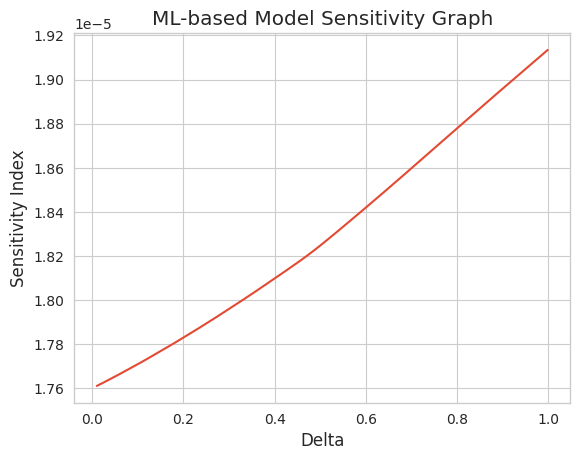

In [65]:
get_sensitivity_graph(model_data, inferred_axes, priorities)


In [ ]:
to_plot = {}
i = 1
for bel in beliefs:
  alternatives = []
  bel_values = []
  all = []
  for k,v in bel.items():
    if len(v) == 1 :
      alternatives.append(v[0])
      bel_values.append(k[0])
  all.append(alternatives)
  all.append(bel_values)
  to_plot[str(i)] = all
  i += 1

In [ ]:
to_plot

{'1': [['Alternative 1',
   'Alternative 4',
   'Alternative 2',
   'Alternative 5',
   'Alternative 3'],
  [0.09223503591407986,
   0.24684373485148592,
   0.2523972046046709,
   0.05638860555327436,
   0.3302479728998334]],
 '2': [['Alternative 1',
   'Alternative 4',
   'Alternative 2',
   'Alternative 5',
   'Alternative 3'],
  [0.07111501562267387,
   0.2236377572771761,
   0.47432272978810053,
   0.04533261772886769,
   0.17435606677794646]],
 '3': [['Alternative 1',
   'Alternative 4',
   'Alternative 2',
   'Alternative 5',
   'Alternative 3'],
  [0.05501813151228327,
   0.23229662464036643,
   0.5319178409246719,
   0.028736408019227812,
   0.14641373999786478]],
 '4': [['Alternative 1',
   'Alternative 4',
   'Alternative 2',
   'Alternative 5',
   'Alternative 3'],
  [0.10687646364326465,
   0.29588510502972265,
   0.39715358247770755,
   0.04433879077767358,
   0.148902144763817]],
 '5': [['Alternative 1',
   'Alternative 4',
   'Alternative 2',
   'Alternative 5',
   'Alte

In [ ]:
al1 = []
al2= []
al3 = []
al4 = []
al5 = []
for _, v in to_plot.items():
  al1.append(round(v[1][0],2))
  al4.append(round(v[1][1],2))
  al2.append(round(v[1][2],2))
  al5.append(round(v[1][3],2))
  al3.append(round(v[1][4],2))

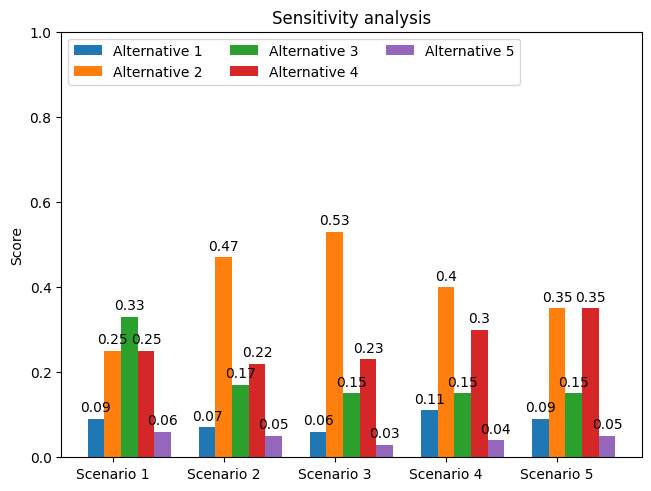

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

sens = ('Scenario 1', "Scenario 2","Scenario 3","Scenario 4","Scenario 5")
data = {
    "Alternative 1": al1,
    "Alternative 2": al2,
    "Alternative 3": al3,
    "Alternative 4": al4,
    "Alternative 5" : al5,
}

x = np.arange(len(sens))  # the label locations
width = 0.15  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in data.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Score')
ax.set_title('Sensitivity analysis')
ax.set_xticks(x + width, sens)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 1)

plt.show()